# Model to Predict Water Potability - 3rd part
## Modeling

After EDA, some conclusions were obtained based on how is the data. First, the data need to be preprocessed because there is a considerable difference between different feature values. Some features have values like 5.0 and others 500.0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/clean_dataset.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,3.716080,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,368.516441,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,368.516441,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
X = df.drop(["Potability"], axis=1)
y = df["Potability"]

### Data Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler
import joblib
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled data:\n", X_scaled[:5, :])
# Save scaler to use on deployment
scaler_path = "models/scaler.save"
joblib.dump(scaler, scaler_path)

Scaled data:
 [[0.26543429 0.57113901 0.33609646 0.54389134 0.68038521 0.66943948
  0.31340165 0.69975313 0.28609102]
 [0.26543429 0.29740043 0.30061142 0.49183921 0.68038521 0.71941108
  0.49731851 0.4509993  0.57679264]
 [0.57850887 0.64131081 0.32161885 0.69854275 0.68038521 0.41465206
  0.56201674 0.5328657  0.30363656]
 [0.59405471 0.60553587 0.35624379 0.60331369 0.64734744 0.31788047
  0.62208906 0.80806473 0.60101542]
 [0.64944453 0.48485088 0.28992169 0.48490019 0.51454537 0.37933671
  0.35855477 0.25360608 0.49632736]]


['models/scaler.save']

### Data Split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                   test_size=0.3, random_state=42)

### Balancing data

The random over-sampling technique will be used to balance the data, _imblearn_ library can help with this case.

In [25]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_o_sampled, y_o_sampled = ros.fit_resample(X_train, y_train)

In [26]:
from collections import Counter
print("Before over-sampling: ")
print(sorted(Counter(y_train).items()))
print("\nAfter over-sampling: ")
print(sorted(Counter(y_o_sampled).items()))

Before over-sampling: 
[(0, 1381), (1, 912)]

After over-sampling: 
[(0, 1381), (1, 1381)]


Training data is still imbalanced, but after applying oversampling, the data has the same number for each class. The data will be under-sampled to train another model and compare performances.

In [27]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_u_sampled, y_u_sampled = rus.fit_resample(X_train, y_train)
print("Before under-sampling: ")
print(sorted(Counter(y_train).items()))
print("\nAfter under-sampling: ")
print(sorted(Counter(y_u_sampled).items()))

Before under-sampling: 
[(0, 1381), (1, 912)]

After under-sampling: 
[(0, 912), (1, 912)]


With that samples the next step is train the models, based on the EDA the models for this problem will be Support Vector Classifier (SVC), KNeighborsClassifier, GaussianProcessClassifier and Categorical Naive Bayes (CategoricalNB).  

In [29]:
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
# Metrics
from sklearn.metrics import accuracy_score

def model_training(models, names, X_train, X_test, y_train, y_test):
    for idx, clf in enumerate(models):
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        score = accuracy_score(y_test, predictions)
        print(f"Accuracy score with {names[idx]} model: {score}")

models = [
    SVC(gamma=2, C=1),
    KNeighborsClassifier(n_neighbors=3),
    GaussianProcessClassifier(),
    CategoricalNB()
]

model_names = [
    "SVC",
    "KNeighborsClassifier",
    "GaussianProcessClassifier",
    "CategoricalNB"
]

print("=========================================")
print("          WITH OVERSAMPLED DATA          ")
print("=========================================")
model_training(models, model_names, X_o_sampled, X_test, y_o_sampled, y_test)
print("=========================================")
print("          WITH UNDERSAMPLED DATA          ")
print("=========================================")
model_training(models, model_names, X_u_sampled, X_test, y_u_sampled, y_test)

          WITH OVERSAMPLED DATA          
Accuracy score with SVC model: 0.6653102746693794
Accuracy score with KNeighborsClassifier model: 0.6063072227873856
Accuracy score with GaussianProcessClassifier model: 0.6154628687690743
Accuracy score with CategoricalNB model: 0.6276703967446592
          WITH UNDERSAMPLED DATA          
Accuracy score with SVC model: 0.6602238046795524
Accuracy score with KNeighborsClassifier model: 0.5890132248219736
Accuracy score with GaussianProcessClassifier model: 0.5768056968463886
Accuracy score with CategoricalNB model: 0.6276703967446592


With the oversampled data, the results were better. SVC and CategoricalNB got the best performance. 

The next step is to find the best parameters for these models and save the best for deployment.

### Hyper-parameter tuning

Before deployment, we must tune it to find the best parameters and get the best performance to make a better model.

In [38]:
from sklearn.model_selection import GridSearchCV
# Classifiers
cnb = CategoricalNB()
kneighbors = KNeighborsClassifier()
svc = SVC()

# Parameters
cnb_parm = {
    "alpha": [0.01, 0.1, 0.5, 0.8, 1, 1.5, 2, 5],
    "fit_prior": [True, False]
}
kneighbors_parm = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}
svc_parm = {
    "C": [0.1, 0.5, 0.8, 1, 1.5, 2, 3],
    "gamma": [0.001, 0.005, 0.1, 0.5, 0.8, 1, 1.5, 2, 3, 5, 7],
    "probability": [True, False]
}

# Tuned Classifiers
cnb_clf = GridSearchCV(cnb, cnb_parm)
kneighbors_clf = GridSearchCV(kneighbors, kneighbors_parm)
svc_clf = GridSearchCV(svc, svc_parm)

In [39]:
%%capture --no-display
# Training
cnb_clf.fit(X_o_sampled, y_o_sampled)
kneighbors_clf.fit(X_o_sampled, y_o_sampled)
svc_clf.fit(X_o_sampled, y_o_sampled)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 0.8, 1, 1.5, 2, 3],
                         'gamma': [0.001, 0.005, 0.1, 0.5, 0.8, 1, 1.5, 2, 3, 5,
                                   7],
                         'probability': [True, False]})

In [41]:
print("Best parameters for SVC: ", svc_clf.best_params_)
print("Best parameters for KNeighborsClassifier: ", kneighbors_clf.best_params_)
print("Best parameters for CategoricalNB: ", cnb_clf.best_params_)

Best parameters for SVC:  {'C': 3, 'gamma': 7, 'probability': True}
Best parameters for KNeighborsClassifier:  {'algorithm': 'auto', 'n_neighbors': 1}
Best parameters for CategoricalNB:  {'alpha': 0.01, 'fit_prior': True}


Let's see how is the new score with that parameters.

In [42]:
tuned_svc = SVC(C=3, gamma=7, probability=True)
tuned_svc.fit(X_o_sampled, y_o_sampled)
svc_predictions = tuned_svc.predict(X_test)
svc_score = accuracy_score(y_test, svc_predictions)
print("SVC score: ", svc_score)

SVC score:  0.6531027466937945


In [43]:
tuned_cnb = CategoricalNB(alpha=0.01, fit_prior=True)
tuned_cnb.fit(X_o_sampled, y_o_sampled)
cnb_predictions = tuned_cnb.predict(X_test)
cnb_score = accuracy_score(y_test, cnb_predictions)
print("CategoricalNB score: ", cnb_score)

SVC score:  0.6276703967446592


In [44]:
tuned_kn = KNeighborsClassifier(n_neighbors=1, algorithm='auto')
tuned_kn.fit(X_o_sampled, y_o_sampled)
kn_predictions = tuned_kn.predict(X_test)
kn_score = accuracy_score(y_test, kn_predictions)
print("KNeighbors score: ", kn_score)

KNeighbors score:  0.5961342828077314


There is no good performance concerning the first training; let's try with an ensemble method.

In [48]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
# Classifiers
ada_clf = AdaBoostClassifier(n_estimators=100)
baggin_clf = BaggingClassifier(n_estimators=100)
forest_clf = RandomForestClassifier(n_estimators=100)

# Training
ada_clf.fit(X_o_sampled, y_o_sampled)
baggin_clf.fit(X_o_sampled, y_o_sampled)
forest_clf.fit(X_o_sampled, y_o_sampled)

RandomForestClassifier()

In [49]:
# Predictions
ada_pred = ada_clf.predict(X_test)
bagging_pred = baggin_clf.predict(X_test)
forest_pred = forest_clf.predict(X_test)

# Get scores
ada_score = accuracy_score(y_test, ada_pred)
bagging_score = accuracy_score(y_test, bagging_pred)
forest_score = accuracy_score(y_test, forest_pred)
print(f"AdaBoost accuracy score: {ada_score*100:.2f}%")
print(f"Bagging accuracy score: {bagging_score*100:.2f}%")
print(f"RandomForest accuracy score: {forest_score*100:.2f}%")

AdaBoost accuracy score: 60.33%
Bagging accuracy score: 69.38%
RandomForest accuracy score: 68.36%


Bagging classifier got the best performance with 69.38% on accuracy score. Let's see other metrics and then save the model for deploying it.

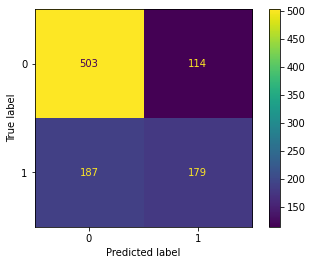

In [85]:
%%capture --no-display
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(baggin_clf, X_test, y_test)
plt.show()

In [55]:
train_pred = baggin_clf.predict(X_o_sampled)
train_score = accuracy_score(y_o_sampled, train_pred)
print(f"Accuracy score for training data: {train_score*100:.2f}%")

Accuracy score for training data: 100.00%


With bagging, the model is getting overfitting; let's see how the other models are performing.

In [59]:
train_forest_pred = forest_clf.predict(X_o_sampled)
train_forest_score = accuracy_score(y_o_sampled, train_forest_pred)
print(f"Accuracy score for training data with RandomForestClassifier: {train_forest_score*100:.2f}%")
train_ada_pred = ada_clf.predict(X_o_sampled)
train_ada_score = accuracy_score(y_o_sampled, train_ada_pred)
print(f"Accuracy score for training data with AdaBoostClassifier: {train_forest_score*100:.2f}%")

Accuracy score for training data with RandomForestClassifier: 100.00%
Accuracy score for training data with AdaBoostClassifier: 100.00%


Those models have better accuracy scores but with overfitting. Let's check with SVC:

In [82]:
svc_1 = SVC(gamma=1, C=3)
svc_1.fit(X_o_sampled, y_o_sampled)
svc_train_pred = svc_1.predict(X_o_sampled)
svc_train_score = accuracy_score(y_o_sampled, svc_train_pred)
print(f"Accuracy score for training data with SVC: {svc_train_score*100:.2f}%")
svc_preds = svc_1.predict(X_test)
svc_1_score = accuracy_score(y_test, svc_preds)
print(f"Accuracy score for testing data with SVC: {svc_1_score*100:.2f}%")

Accuracy score for training data with SVC: 63.03%
Accuracy score for testing data with SVC: 67.04%


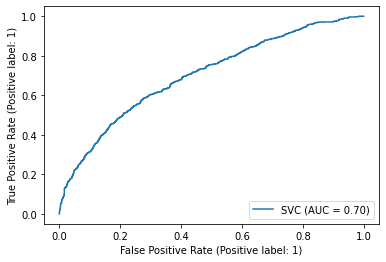

In [90]:
%%capture --no-display
from sklearn.metrics import plot_roc_curve
plot_roc_curve(svc_1, X_o_sampled, y_o_sampled)

The SVC model isn't getting overfitting, and for testing data, the model show 67% of accuracy. The next step is to save the model and deploy it to make the first tests on a web app.

In [83]:
model_path = "models/svc.save"
joblib.dump(svc_1, model_path)

['models/svc.save']